<div style="text-align: center;"> <h1> FURIA Know Your Fan </h1> </div>

<div style="text-align: center;"> <h3> Todos os pip, ferramentas e bibliotecas utilizadas </h3> </div>

- pip install python-dotenv ipywidgets cryptography

<div style="text-align: center;"> <h3> Chave API Oculta (Arquivo .env) </h3> </div>

In [ ]:
from dotenv import load_dotenv
import os

from oauthlib.oauth2 import BearerToken

# Carregar variáveis do .env
load_dotenv()

chave_api = os.getenv('API_KEY')

<div style="text-align: center;"> <h3>Coleta de Dados Básicos e Interesses Relacionados à FURIA</h3> </div>
  
- **Formulário Inicial:** Criar um formulário em Jupyter Notebook (usando `ipywidgets` ou `Streamlit`) para capturar dados pessoais fundamentais: nome, CPF, endereço, data de nascimento, email etc. Validar formato de CPF (biblioteca `python-bcpf` ou validação via regex) e outros campos para evitar erros de digitação.  

- **Interesses e Atividades em e-sports:** Incluir no notebook seções ou perguntas interativas sobre interesses em e-sports, times preferidos (FURIA), jogos mais acompanhados, frequência de eventos assistidos, ingressos ou periféricos adquiridos no último ano. Utilizar `pandas` para estruturar as respostas em um DataFrame. Poder-se-á simular coleta de dados de APIs públicas de eventos (por exemplo, dados de torneios CS:GO) ou pedir ao usuário que importe seu histórico (como um CSV de compras) para preencher esse perfil de maneira realista.  

- **Compras Relacionadas:** Se for aplicável, permitir o upload de extratos simplificados ou listas de compras (como merch de teams e-sports). Usar `pandas` ou `openpyxl` para ler esses arquivos e filtrar itens de interesse (palavras-chave relacionadas a jogos, marcas de e-sports, etc).

In [ ]:
import http.server
import socketserver
import webbrowser
import json
import uuid
import os
import hashlib
import threading
import base64
from datetime import datetime
from cryptography.fernet import Fernet

PORT = 8080
DATA_DIR = "form_data"
KEY_FILE = "rg_encryption.key"

# Carrega ou gera a chave de criptografia
if not os.path.exists(KEY_FILE):
    key = Fernet.generate_key()
    with open(KEY_FILE, 'wb') as kf:
        kf.write(key)
else:
    with open(KEY_FILE, 'rb') as kf:
        key = kf.read()
fernet = Fernet(key)

class MyHandler(http.server.SimpleHTTPRequestHandler):
    def do_POST(self):
        # Só processa a rota '/submit'
        if self.path != '/submit':
            return super().do_GET()

        # Lê o corpo da requisição como JSON
        content_length = int(self.headers.get('Content-Length', 0))
        raw_body = self.rfile.read(content_length).decode('utf-8')
        try:
            dados = json.loads(raw_body)
        except json.JSONDecodeError:
            self.send_error(400, "Bad Request: JSON inválido")
            return

        # Hash do CPF
        cpf_original = dados.get('cpf')
        if cpf_original:
            dados['cpf'] = hashlib.sha256(cpf_original.encode('utf-8')).hexdigest()
        else:
            print("Aviso: 'cpf' não enviado.")

        # Extrai imagens em Base64 do JSON
        rg_base64     = dados.pop('rgImagem_base64', None)
        selfie_base64 = dados.pop('selfieImagem_base64', None)

        # Adiciona timestamp de submissão
        dados['submitted_at'] = datetime.utcnow().isoformat() + 'Z'

        # Gera ID único e prepara diretório
        user_id = str(uuid.uuid4())
        os.makedirs(DATA_DIR, exist_ok=True)

        # Criptografa e salva RG como arquivo .enc
        if rg_base64:
            try:
                rg_bytes = base64.b64decode(rg_base64)
                encrypted = fernet.encrypt(rg_bytes)
                enc_filename = f"{user_id}_rg.enc"
                enc_path = os.path.join(DATA_DIR, enc_filename)
                with open(enc_path, 'wb') as ef:
                    ef.write(encrypted)
                dados['rgImagem_encrypted'] = enc_filename
            except Exception as e:
                print(f"Erro ao criptografar/salvar RG: {e}")

        # Salva selfie como PNG (ou também criptografe se desejar)
        if selfie_base64:
            try:
                selfie_bytes = base64.b64decode(selfie_base64)
                selfie_filename = f"{user_id}_selfie.png"
                selfie_path = os.path.join(DATA_DIR, selfie_filename)
                with open(selfie_path, 'wb') as imgf:
                    imgf.write(selfie_bytes)
                dados['selfieImagem_file'] = selfie_filename
            except Exception as e:
                print(f"Erro ao salvar Selfie: {e}")

        # Grava JSON de metadados de forma atômica
        file_path = os.path.join(DATA_DIR, f"{user_id}.json")
        temp_path = file_path + ".tmp"
        try:
            with open(temp_path, 'w', encoding='utf-8') as f:
                json.dump(dados, f, indent=4, ensure_ascii=False)
            os.replace(temp_path, file_path)
        except Exception as e:
            print(f"Erro ao salvar JSON: {e}")
            self.send_error(500, "Internal Server Error: falha ao salvar dados")
            return

        print(f"Dados salvos (metadados + RG criptografado) em: {DATA_DIR}")

        # Envia resposta de sucesso
        response = {
            'status': 'success',
            'message': 'Dados eviados e criptografados com sucesso!',
            'user_id': user_id
        }
        self.send_response(200)
        self.send_header('Content-Type', 'application/json')
        self.end_headers()
        self.wfile.write(json.dumps(response).encode('utf-8'))

        # Desliga o servidor após 4 segundos
        threading.Timer(4.0, self.server.shutdown).start()


def run_server():
    with socketserver.TCPServer(("", PORT), MyHandler) as httpd:
        print(f"Servidor rodando em http://localhost:{PORT}")
        webbrowser.open(f"http://localhost:{PORT}/Form/form.html")
        httpd.serve_forever()

if __name__ == "__main__":
    run_server()


<div style="text-align: center;"> <h3>Validação de Identidade com Abordagem de IA</h3> </div>

- **Upload de Documentos:** Incluir um widget de upload de arquivos de imagem (RG, CNH ou passaporte) e, opcionalmente, uma selfie do usuário.  
- **OCR e Extração de Dados:** Utilizar uma biblioteca de OCR como `pytesseract` ou `easyocr` para extrair texto do documento. Comparar nome e CPF extraídos com os dados básicos fornecidos para consistência.  
- **Reconhecimento Facial:** Para fortalecer a validação, aplicar uma técnica de reconhecimento facial simples. Usar bibliotecas como `face_recognition` ou `OpenCV` com modelos pré-treinados para detectar rostos na selfie e na foto do documento, e então verificar se pertencem à mesma pessoa (por exemplo, comparando descritores faciais).  
- **Feedback de Validação:** Exibir no notebook resultados da validação (válido/inválido) com base na correspondência de texto e face. Fornecer mensagens orientativas caso haja inconsistências (ex: “CPF não confere com o documento enviado”).

### Instale as bibliotecas necessárias

- pytesseract (requer Tesseract OCR engine instalado separadamente)
 
- Pillow (dependência do pytesseract)
 
- face_recognition (requer dlib, pode ser complexo instalar em alguns sistemas)

- ipywidgets (para o widget de upload)

<br>

```pip install pytesseract Pillow face_recognition ipywidgets ```


<div style="text-align: center;"> <h3>OCR, Extração e Comparação de Dados Textuais</h3> </div>


Definimos uma função para realizar o OCR na imagem do documento completo, extrair o texto, tentar encontrar Nome e CPF e compará-los com dados fornecidos (vamos simular esses dados fornecidos para o exemplo).

In [ ]:
%pip install tesseract pytesseract

### Validação Nome e Naturalidade (OCR)

In [ ]:
import os
import io
import json
import re

from PIL import Image
import numpy as np
import cv2
import pytesseract
from cryptography.fernet import Fernet

# ————————— Configurações Tesseract —————————
os.environ["TESSDATA_PREFIX"] = r"C:\Program Files\Tesseract-OCR\tessdata"
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
# OCR geral, dígitos e whitelist MRZ
TESS_FULL   = "--oem 3 --psm 3"
TESS_DIGITS = "--oem 3 --psm 3 -c tessedit_char_whitelist=0123456789"
TESS_MRZ    = "--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ<"

DATA_DIR  = "form_data"
KEY_FILE  = "rg_encryption.key"

# ————————— Carrega chave e dados do JSON mais recente —————————
fernet        = Fernet(open(KEY_FILE, "rb").read())
json_files    = sorted(
    [f for f in os.listdir(DATA_DIR) if f.endswith(".json")],
    key=lambda fn: os.path.getmtime(os.path.join(DATA_DIR, fn)),
    reverse=True
)
user_id       = os.path.splitext(json_files[0])[0]
form_data     = json.load(open(os.path.join(DATA_DIR, json_files[0]), encoding="utf-8"))
provided_name = form_data.get("nome", "")
cpf_hash      = form_data.get("cpf", "")

# ————————— Decrypt + carrega imagem em alta resolução (×2) —————————
encrypted = form_data["rgImagem_encrypted"]
raw       = fernet.decrypt(open(os.path.join(DATA_DIR, encrypted), "rb").read())
pil       = Image.open(io.BytesIO(raw)).convert("RGB")
pil       = pil.resize((pil.width * 2, pil.height * 2), Image.LANCZOS)
img       = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)

# ————————— Pré-processamento —————————
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(gray)
_, prep = cv2.threshold(cl, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ————————— OCR completo (para debug) —————————
full_ocr_text = pytesseract.image_to_string(prep, config=TESS_FULL, lang="por+eng")

# ————————— Função de validação de CPF —————————
def valida_cpf(c: str) -> bool:
    if len(c) != 11 or c == c[0]*11:
        return False
    s1 = sum(int(c[i])*(10-i) for i in range(9))
    d1 = ((s1*10) % 11) % 10
    s2 = sum(int(c[i])*(11-i) for i in range(10))
    d2 = ((s2*10) % 11) % 10
    return c[-2:] == f"{d1}{d2}"

# ————————— Extrai Nome via MRZ —————————
name = None
name_ocr_raw = None
mrz_lines = [L.strip() for L in full_ocr_text.splitlines() if "<<" in L]
if mrz_lines:
    mrz = mrz_lines[-1]
    parts = mrz.split("<<")
    if len(parts) >= 2:
        surname    = parts[0].title()
        given_list = [p for p in parts[1].split("<") if p]
        given_list = list(reversed(given_list))
        name       = " ".join(p.title() for p in given_list + [surname])
        name_ocr_raw = mrz

def normalize(n: str) -> str:
    t = re.sub(r'\b(?:de|da|dos|das|do)\b','', n, flags=re.IGNORECASE)
    return re.sub(r'\s+','', t).lower()

name_match = bool(name and normalize(name) == normalize(provided_name))
if name_match:
    name = provided_name  # ajusta para o formato original


import os
import io
import json
import re
import hashlib

from PIL import Image
import numpy as np
import cv2
import pytesseract
from cryptography.fernet import Fernet

# ————————— Configurações Tesseract —————————
os.environ["TESSDATA_PREFIX"] = r"C:\Program Files\Tesseract-OCR\tessdata"
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
TESS_CONF        = "--oem 3 --psm 6"
TESS_CONF_DIGITS = "--oem 3 --psm 6 -c tessedit_char_whitelist=0123456789.-"
TESS_CONF_MRZ    = "--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ<"

DATA_DIR  = "form_data"
KEY_FILE  = "rg_encryption.key"

# ————————— Carrega chave e dados do JSON mais recente —————————
fernet        = Fernet(open(KEY_FILE, "rb").read())
json_files    = sorted(
    [f for f in os.listdir(DATA_DIR) if f.endswith(".json")],
    key=lambda fn: os.path.getmtime(os.path.join(DATA_DIR, fn)),
    reverse=True
)
user_id       = os.path.splitext(json_files[0])[0]
form_data     = json.load(open(os.path.join(DATA_DIR, json_files[0]), encoding="utf-8"))
provided_name = form_data.get("nome", "")
cpf_hash      = form_data.get("cpf", "")

# ————————— Decrypt + carrega imagem em alta resolução (×2) —————————
encrypted = form_data["rgImagem_encrypted"]
raw       = fernet.decrypt(open(os.path.join(DATA_DIR, encrypted), "rb").read())
pil       = Image.open(io.BytesIO(raw)).convert("RGB")
pil       = pil.resize((pil.width * 2, pil.height * 2), Image.LANCZOS)
img       = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)

# ————————— Pré-processamento —————————
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(gray)
_, prep = cv2.threshold(cl, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# ————————— OCR completo (para debug) —————————
full_ocr_text = pytesseract.image_to_string(prep, config=TESS_CONF)

# ————————— Extrai Nome via MRZ —————————
name = None
name_ocr_raw = None
mrz_lines = [L.strip() for L in full_ocr_text.splitlines() if "<<" in L]
if mrz_lines:
    mrz = mrz_lines[-1]
    parts = mrz.split("<<")
    if len(parts) >= 2:
        surname    = parts[0].title()
        given_list = [p for p in parts[1].split("<") if p]
        given_list = list(reversed(given_list))
        name       = " ".join(p.title() for p in given_list + [surname])
        name_ocr_raw = mrz

def normalize(n: str) -> str:
    t = re.sub(r'\b(?:de|da|dos|das|do)\b','', n, flags=re.IGNORECASE)
    return re.sub(r'\s+','', t).lower()

name_match = bool(name and normalize(name) == normalize(provided_name))
if name_match:
    name = provided_name  # ajusta para o formato original

# ————————— Extração da Naturalidade —————————
naturalidade = None
naturalidade_match = False

# 1) Tenta padrões genéricos: “Naturalidade: Cidade – UF”
m = re.search(
    r'(?:Naturalidade|Natural de|Natural)\s*[:\-]?\s*([\wÀ-ú\s]+)[-/]?\s*([A-Za-z]{2})',
    full_ocr_text,
    flags=re.IGNORECASE
)
if m:
    cidade = m.group(1).strip().title()
    estado = m.group(2).strip().upper()
    naturalidade = f"{cidade} - {estado}"
else:
    # 2) Fallback: “ESTADO DE <Cidade> <UF>”
    f = re.search(
        r'ESTADO DE\s+([\wÀ-ú]+)\s+([A-Za-z]{2})',
        full_ocr_text,
        flags=re.IGNORECASE
    )
    if f:
        cidade = f.group(1).strip().title()
        estado = f.group(2).strip().upper()
        naturalidade = f"{cidade} - {estado}"

# ————————— Ajuste da comparação para usar "endereco" —————————
expected_city = form_data.get("endereco", "").strip().lower()  # aqui: "utopia"
if naturalidade:
    city_part = naturalidade.split(" - ")[0].strip().lower()
    naturalidade_match = (city_part == expected_city)

# ————————— Resultado Final —————————
result = {
    "full_ocr_text":      full_ocr_text,
    "name":               name,
    "name_ocr_raw":       name_ocr_raw,
    "name_match":         name_match,
    "naturalidade":       naturalidade,
    "naturalidade_match": naturalidade_match
}

# ————————— Atualiza o form_data e salva de volta no JSON —————————
# (1) injeta os novos campos
form_data["naturalidade_extraida"] = naturalidade
form_data["naturalidade_match"]   = naturalidade_match
form_data["name_match"]           = name_match

# (2) reescreve o arquivo JSON
json_path = os.path.join(DATA_DIR, json_files[0])
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(form_data, f, ensure_ascii=False, indent=4)

# (3) opcional: imprime o resultado atualizado
print(json.dumps(result, indent=4, ensure_ascii=False))


### Reconhecimento e Comparação Facial

Agora, definimos uma função para lidar com a comparação facial entre a foto do documento e a selfie

Ao baixar o tesseract, lembrar de baixar a lingua portuguesa e adicionar na pasta -> C:\Program Files\Tesseract-OCR\tessdata

"por.traineddata"

In [ ]:
%pip install opencv-python


In [ ]:
import json
import io
from pathlib import Path
from typing import Any, Dict, Optional

import numpy as np
import cv2
from PIL import Image
from cryptography.fernet import Fernet

# Constants
DATA_DIR = Path("form_data")
KEY_FILE = Path("rg_encryption.key")
CASCADE_PATH = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
FACE_SIZE = (150, 150)
DISTANCE_THRESHOLD = 60.0  # adjustable threshold for face match

def load_fernet_key(key_path: Path) -> Fernet:
    """
    Load Fernet encryption key from file.
    """
    with key_path.open("rb") as f:
        key = f.read()
    return Fernet(key)


def load_latest_form(data_dir: Path) -> tuple[Dict[str, Any], Path]:
    """
    Load the most recent JSON form from data_dir, returning the data and its file path.
    """
    json_files = sorted(data_dir.glob("*.json"), key=lambda f: f.stat().st_mtime, reverse=True)
    if not json_files:
        raise FileNotFoundError(f"No JSON files found in {data_dir}")
    latest = json_files[0]
    with latest.open("r", encoding="utf-8") as f:
        data = json.load(f)
    # retornamos também o caminho do arquivo JSON para permitir regravação
    return data, latest


def decrypt_image(encrypted_filename: str, fernet: Fernet, data_dir: Path) -> Image.Image:
    """
    Decrypt an image file and return a PIL Image.
    """
    encrypted_path = data_dir / encrypted_filename
    if not encrypted_path.exists():
        raise FileNotFoundError(f"Encrypted file not found: {encrypted_path}")
    data = fernet.decrypt(encrypted_path.read_bytes())
    return Image.open(io.BytesIO(data))


def load_plain_image(filename: str, data_dir: Path) -> Image.Image:
    """
    Load a non-encrypted image from disk as PIL Image.
    """
    img_path = data_dir / filename
    if not img_path.exists():
        raise FileNotFoundError(f"Image file not found: {img_path}")
    return Image.open(img_path)


def pil_to_bgr(img: Image.Image) -> np.ndarray:
    """
    Convert PIL Image to OpenCV BGR numpy array.
    """
    return cv2.cvtColor(np.array(img.convert("RGB")), cv2.COLOR_RGB2BGR)


def detect_face(image_bgr: np.ndarray, cascade: cv2.CascadeClassifier) -> Optional[np.ndarray]:
    """
    Detect the first face in a BGR image, crop and resize it.
    Returns the grayscale face ROI or None.
    """
    faces = cascade.detectMultiScale(image_bgr, scaleFactor=1.1, minNeighbors=5)
    if len(faces) == 0:
        return None
    x, y, w, h = faces[0]
    face = image_bgr[y:y+h, x:x+w]
    face_resized = cv2.resize(face, FACE_SIZE)
    return cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)


def compare_faces(gray1: np.ndarray, gray2: np.ndarray) -> float:
    """
    Compute mean absolute difference between two grayscale face images.
    """
    diff = cv2.absdiff(gray1, gray2)
    return float(np.mean(diff))


def perform_face_comparison_opencv(
    img1_pil: Image.Image, img2_pil: Image.Image, threshold: float = DISTANCE_THRESHOLD
) -> Dict[str, Any]:
    """
    Compare two PIL images containing faces using OpenCV Haar cascades.
    Returns a dict with match result, distance, and status.
    """
    results: Dict[str, Any] = {
        'face_match': False,
        'distance': None,
        'success': False,
        'message': ''
    }
    try:
        img1_bgr = pil_to_bgr(img1_pil)
        img2_bgr = pil_to_bgr(img2_pil)

        cascade = cv2.CascadeClassifier(CASCADE_PATH)
        if cascade.empty():
            raise RuntimeError(f"Failed to load cascade classifier at {CASCADE_PATH}")

        face1 = detect_face(img1_bgr, cascade)
        face2 = detect_face(img2_bgr, cascade)

        if face1 is None or face2 is None:
            results['message'] = "No face detected in one or both images."
            return results

        distance = compare_faces(face1, face2)
        results['distance'] = float(distance)
        results['face_match'] = bool(distance < threshold)
        results['success'] = True
        results['message'] = "Comparison successful with OpenCV."
    except Exception as e:
        results['message'] = f"Error during face comparison: {e}"
    return results


if __name__ == "__main__":
    # Initialize
    fernet = load_fernet_key(KEY_FILE)
    form_data, form_path = load_latest_form(DATA_DIR)

    # Decrypt RG image
    encrypted_rg = form_data.get("rgImagem_encrypted")
    img_doc = decrypt_image(encrypted_rg, fernet, DATA_DIR)

    # Load selfie (not encrypted)
    selfie_filename = form_data.get("selfieImagem_file")
    img_selfie = load_plain_image(selfie_filename, DATA_DIR)

    # Run comparison
    result = perform_face_comparison_opencv(img_doc, img_selfie)

    # Add result index to form data
    form_data['rosto_correto_indice'] = 1 if result.get('face_match') else 0
    form_data['face_match'] = result.get('face_match')
    form_data['face_distance'] = result.get('distance')

    # Save updated JSON back to file
    with form_path.open('w', encoding='utf-8') as f:
        json.dump(form_data, f, indent=4, ensure_ascii=False)

    # Print JSON-safe result
    print(json.dumps(result, indent=4, ensure_ascii=False))


<div style="text-align: center;"> <h3>Integração com Redes Sociais (Simulada)</h3> </div>

- **Linkagem de Contas:** Na ausência de integrações reais, simular o processo solicitando ao usuário os nomes de usuário ou perfis em redes sociais (Twitter, Facebook, Instagram). Criar células de código comentadas que demonstram como usar APIs (ex: `tweepy` para Twitter, `facebook-sdk` para Facebook) para conectar as contas.  
- **Extração de Atividades Relacionadas a e-sports:** Para cada rede social simulada, mostrar como coletar dados relevantes: por exemplo, obter os últimos *tweets* do usuário e filtrar menções a e-sports ou FURIA; listar as páginas seguidas no Facebook com temas de gaming; ou verificar hashtags usadas em posts do Instagram. Usar `requests` e `BeautifulSoup` ou clientes de API para simulação. Armazenar essas informações em DataFrames para análise.  
- **Monitoramento de Interações:** Demonstrar código que analisa curtidas, comentários ou retweets em publicações de e-sports (fingindo as permissões de API). Por exemplo, usar `tweepy` para buscar tweets que mencionem FURIA ou eventos de e-sports que o usuário retuitou ou comentou.  

### Twitter (usuário individual)

In [ ]:
import os
import json
import tweepy
from dotenv import load_dotenv
from pathlib import Path

env_path = Path('.idea/.env')  # ex: Path('config/.env')
load_dotenv(dotenv_path=env_path)

chave_api = os.getenv("twitter_api")

# ————————— Configurações e autenticação —————————
BEARER_TOKEN = chave_api  # Substitua pelo seu Bearer Token

client = tweepy.Client(bearer_token=BEARER_TOKEN)
# ————————— Carrega JSON com dados do usuário —————————
DATA_DIR = 'form_data'
json_files = sorted([
    f for f in os.listdir(DATA_DIR) if f.endswith('.json')
], key=lambda fn: os.path.getmtime(os.path.join(DATA_DIR, fn)), reverse=True)
json_path = os.path.join(DATA_DIR, json_files[0])
form_data = json.load(open(json_path, encoding='utf-8'))

# Extrai o username (sem o @) que está salvo no JSON, ex: "@teste" ou "teste"
raw_handle = form_data.get('twitter', '').strip()
twitter_handle = raw_handle.lstrip('@')
if not twitter_handle:
    raise ValueError('Nenhum handle de Twitter encontrado no JSON')

# ————————— Termos específicos a buscar —————————
TERMS = [
    'Fallen', 'KSCERATO', 'yuurih', 'molodoy', 'skullz', 'chelo',
    'fNb', 'Goot', 'Envy', 'Trigo', 'RedBert', 'Fntzy', 'R4re',
    'Handyy', 'KDS', 'yanxnz', 'Lostt', 'nzr', 'Khalil', 'havoc',
    'xand', 'mwzera', 'Xeratricky', 'Pandxrz', 'HisWattson',
    '#FURIACS', '#FURIAR6', '#FURIAFC', '#DIADEFURIA'
]

# Monta query para buscar tweets do usuário contendo qualquer termo
query_terms = ' OR '.join(f'"{t}"' for t in TERMS)
query = f'from:{twitter_handle} ({query_terms}) -is:retweet lang:pt'

# ————————— Busca tweets —————————
max_results = 15  # até 100
response = client.search_recent_tweets(
    query=query,
    max_results=max_results,
    tweet_fields=['id', 'text', 'created_at', 'lang', 'source'],
    expansions=['author_id'],
    user_fields=['username', 'name', 'description', 'location']
)

# ————————— Monta resultados para salvar —————————
tweets_data = []
if response.data:
    users_index = {u['id']: u for u in response.includes.get('users', [])}
    for tweet in response.data:
        info = {
            'tweet_id': tweet.id,
            'text': tweet.text,
            'created_at': str(tweet.created_at),
            'lang': tweet.lang,
            'source': tweet.source,
            'author': {
                'id': tweet.author_id,
                'username': users_index[tweet.author_id].username,
                'name': users_index[tweet.author_id].name,
            }
        }
        tweets_data.append(info)

# ————————— Salva em JSON —————————
output_path = os.path.join(DATA_DIR, f'tweets_User.json')
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(tweets_data, f, ensure_ascii=False, indent=4)

print(f"Salvos {len(tweets_data)} tweets em {output_path}")



### Youtube (Análise Geral de Fãs)

Link do Vídeo (Código)

In [ ]:
import os
import json
from googleapiclient.discovery import build
from dotenv import load_dotenv
from pathlib import Path

env_path = Path('.idea/.env')  # ex: Path('config/.env')
load_dotenv(dotenv_path=env_path)

# Testa se a chave da API está sendo carregada
api_key = os.getenv("YOUTUBE_API_KEY")


# ID do vídeo do qual você quer obter os comentários
video_id = '8aIcU-_5W34'


def get_video_channel_name(video_id, api_key):
    # Conectando à API do YouTube
    youtube = build('youtube', 'v3', developerKey=api_key)
    
    # Obtém as informações do vídeo
    request = youtube.videos().list(
        part='snippet',
        id=video_id
    )
    
    # Realiza a requisição e pega o nome do canal
    response = request.execute()
    if response['items']:
        channel_name = response['items'][0]['snippet']['channelTitle']
        return channel_name
    return None

# Função para obter comentários do vídeo
def get_comments(video_id, api_key):
    # Conectando à API do YouTube
    youtube = build('youtube', 'v3', developerKey=api_key)
    
    # Lista para armazenar os comentários
    comments = []
    
    channel_name = get_video_channel_name(video_id, api_key)
    
    # Inicializa a requisição para obter os comentários
    request = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        textFormat='plainText',
        maxResults=100  # Max resultados por requisição (pode ajustar conforme necessário)
    )
    
    # Realiza a requisição
    while request:
        response = request.execute()
        
        # Itera sobre os comentários e armazena os dados
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comment_data = {
                    'video_id': video_id,                    # ← aqui você adiciona o ID do vídeo
                    'author': comment['authorDisplayName'],
                    'text': comment['textDisplay'],
                    'published_at': comment['publishedAt'],
                    'likes': comment['likeCount'],
                    'channel_name': channel_name
                }
            
            comments.append(comment_data)
        
        # Verifica se existe uma próxima página de resultados
        request = youtube.commentThreads().list_next(request, response)
    
    return comments

# Obter os comentários
# Função para salvar os comentários sem sobrescrever o arquivo existente
def save_comments(comments, filename='comentarios_video.json'):
    # Caminho da pasta onde você deseja salvar o arquivo
    pasta = 'form_data'

    # Certifique-se de que a pasta existe
    if not os.path.exists(pasta):
        os.makedirs(pasta)

    # Caminho completo do arquivo JSON
    arquivo_json = os.path.join(pasta, filename)
    
    # Verifica se o arquivo já existe
    if os.path.exists(arquivo_json):
        # Carrega o conteúdo existente
        with open(arquivo_json, 'r', encoding='utf-8') as f:
            existing_comments = json.load(f)
        
        # Adiciona os novos comentários ao conteúdo existente
        existing_comments.extend(comments)
        
        # Salva o conteúdo atualizado
        with open(arquivo_json, 'w', encoding='utf-8') as f:
            json.dump(existing_comments, f, indent=4, ensure_ascii=False)
    else:
        # Caso o arquivo não exista, cria um novo com os comentários
        with open(arquivo_json, 'w', encoding='utf-8') as f:
            json.dump(comments, f, indent=4, ensure_ascii=False)

# Obter os comentários
comments = get_comments(video_id, api_key)

# Salvar os comentários sem sobrescrever o arquivo
save_comments(comments)

print("Comentários salvos em 'form_data/comentarios_video.json'")

GUI (Custom Tkinter)

In [ ]:
%pip install customtkinter google-api-python-client python-dotenv

In [ ]:
import os
import json
import customtkinter as ctk
from googleapiclient.discovery import build
from dotenv import load_dotenv
from pathlib import Path
import re
import tkinter.messagebox as msgbox

# Load .env
env_path = Path('.idea/.env')  # Ajuste conforme necessário
load_dotenv(dotenv_path=env_path)
api_key = os.getenv("YOUTUBE_API_KEY")

# Detecta ID do vídeo
def extract_video_id(url):
    match = re.search(r"(?:v=|youtu\.be/)([a-zA-Z0-9_-]{11})", url)
    return match.group(1) if match else None

# Detecta ID da playlist
def extract_playlist_id(url):
    match = re.search(r"[?&]list=([a-zA-Z0-9_-]+)", url)
    return match.group(1) if match else None

# Pega nome do canal
def get_video_channel_name(video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    request = youtube.videos().list(part='snippet', id=video_id)
    response = request.execute()
    if response['items']:
        return response['items'][0]['snippet']['channelTitle']
    return None

# Busca comentários
def get_comments(video_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    comments = []
    channel_name = get_video_channel_name(video_id)
    request = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        textFormat='plainText',
        maxResults=100
    )
    while request:
        response = request.execute()
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']
            comment_data = {
                'video_id': video_id,
                'author': comment['authorDisplayName'],
                'text': comment['textDisplay'],
                'published_at': comment['publishedAt'],
                'likes': comment['likeCount'],
                'channel_name': channel_name
            }
            comments.append(comment_data)
        request = youtube.commentThreads().list_next(request, response)
    return comments

# Salva no JSON
def save_comments(comments, filename='comentarios_video.json'):
    pasta = 'form_data'
    os.makedirs(pasta, exist_ok=True)
    caminho = os.path.join(pasta, filename)
    if os.path.exists(caminho):
        with open(caminho, 'r', encoding='utf-8') as f:
            existentes = json.load(f)
        existentes.extend(comments)
        with open(caminho, 'w', encoding='utf-8') as f:
            json.dump(existentes, f, indent=4, ensure_ascii=False)
    else:
        with open(caminho, 'w', encoding='utf-8') as f:
            json.dump(comments, f, indent=4, ensure_ascii=False)

# Busca vídeos de uma playlist
def get_video_ids_from_playlist(playlist_id):
    youtube = build('youtube', 'v3', developerKey=api_key)
    video_ids = []
    request = youtube.playlistItems().list(
        part='contentDetails',
        playlistId=playlist_id,
        maxResults=50
    )
    while request:
        response = request.execute()
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        request = youtube.playlistItems().list_next(request, response)
    return video_ids

# Processa link inserido
def process_link():
    url = entry_url.get().strip()
    if not url:
        status_label.configure(text="Cole um link válido do YouTube.", text_color="red")
        return

    playlist_id = extract_playlist_id(url)
    video_id = extract_video_id(url)

    if playlist_id:
        try:
            video_ids = get_video_ids_from_playlist(playlist_id)
            total_comments = []
            for vid in video_ids:
                status_label.configure(text=f"Buscando comentários de {vid}...", text_color="blue")
                comments = get_comments(vid)
                total_comments.extend(comments)
            save_comments(total_comments)
            status_label.configure(text=f"Todos os comentários da playlist foram salvos!", text_color="green")
        except Exception as e:
            status_label.configure(text=f"Erro: {e}", text_color="red")
            return

    elif video_id:
        try:
            status_label.configure(text="Buscando comentários do vídeo...", text_color="blue")
            comments = get_comments(video_id)
            save_comments(comments)
            status_label.configure(text=f"Comentários do vídeo foram salvos!", text_color="green")
        except Exception as e:
            status_label.configure(text=f"Erro: {e}", text_color="red")
            return
    else:
        status_label.configure(text="Link inválido. Verifique se é um link do YouTube.", text_color="red")
        return

    # Pergunta se deseja adicionar mais
    continuar = msgbox.askyesno("Continuar", "Deseja adicionar outro vídeo ou playlist?")
    if continuar:
        entry_url.delete(0, 'end')
        status_label.configure(text="Cole outro link para continuar.", text_color="black")
    else:
        app.quit()
        app.destroy()

# GUI com customtkinter
ctk.set_appearance_mode("System")
ctk.set_default_color_theme("blue")

app = ctk.CTk()
app.title("Coletor de Comentários YouTube")
app.geometry("600x300")

label = ctk.CTkLabel(app, text="Cole o link do vídeo ou playlist do YouTube:")
label.pack(pady=10)

entry_url = ctk.CTkEntry(app, width=500)
entry_url.pack(pady=10)

submit_button = ctk.CTkButton(app, text="Buscar e Salvar Comentários", command=process_link)
submit_button.pack(pady=20)

status_label = ctk.CTkLabel(app, text="")
status_label.pack(pady=10)

app.mainloop()


### Análise Geral (Twitter/X)

In [ ]:
import tweepy
import json
import os
from dotenv import load_dotenv
from pathlib import Path

env_path = Path('.idea/.env')  # ex: Path('config/.env')
load_dotenv(dotenv_path=env_path)

chave_api = os.getenv("twitter_api")

# ————————— Configurações e autenticação —————————
BEARER_TOKEN = chave_api  # Substitua pelo seu Bearer Token

client = tweepy.Client(bearer_token=BEARER_TOKEN)

# Parâmetros de pesquisa com a hashtag #DIADEFURIA incluída
query = '(Fallen OR KSCERATO OR yuurih OR molodoy OR skullz OR chelo OR fNb OR Goot OR Envy OR Trigo OR RedBert OR Fntzy OR R4re OR Handyy OR KDS OR yanxnz OR Lostt OR nzr OR Khalil OR havoc OR xand OR mwzera OR Xeratricky OR Pandxrz OR HisWattson OR #FURIACS OR #FURIAR6 OR #FURIAFC OR #DIADEFURIA) -is:retweet lang:pt'
max_results = 10

# Fazendo a busca com os campos desejados
tweets = client.search_recent_tweets(query=query, max_results=max_results,
                                     tweet_fields=["author_id", "conversation_id", "created_at", "geo", "id", "lang", "source", "text"],
                                     user_fields=["created_at", "description", "entities", "id", "location", "name", "url", "username"],
                                     expansions=["author_id"])

# Convertendo os tweets para um formato de dicionário
tweets_data = []
if tweets.data:
    for tweet in tweets.data:
        tweet_info = {
            'tweet_id': tweet.id,
            'text': tweet.text,
            'created_at': str(tweet.created_at),
            'author_id': tweet.author_id,
            'conversation_id': tweet.conversation_id,
            'geo': tweet.geo,
            'lang': tweet.lang,
            'source': tweet.source
        }

        # Obtendo informações do usuário (quem postou o tweet)
        if tweets.includes and 'users' in tweets.includes:
            for user in tweets.includes['users']:
                if user.id == tweet.author_id:
                    tweet_info['user'] = {
                        'created_at': str(user.created_at),
                        'description': user.description,
                        'entities': user.entities,
                        'location': user.location,
                        'name': user.name,
                        'url': user.url,
                        'username': user.username
                    }
                    break

        tweets_data.append(tweet_info)

# Caminho da pasta onde você deseja salvar o arquivo
pasta = 'form_data'

# Certifique-se de que a pasta existe
if not os.path.exists(pasta):
    os.makedirs(pasta)

# Caminho completo do arquivo JSON
arquivo_json = os.path.join(pasta, 'tweetsGerais_furia.json')

# Carrega o conteúdo existente, se houver
if os.path.exists(arquivo_json):
    with open(arquivo_json, 'r', encoding='utf-8') as f:
        dados_existentes = json.load(f)
else:
    dados_existentes = []

# Adiciona os novos tweets
dados_existentes.extend(tweets_data)

# Salva de volta no JSON
with open(arquivo_json, 'w', encoding='utf-8') as f:
    json.dump(dados_existentes, f, ensure_ascii=False, indent=4)

print("Tweets adicionados com sucesso a 'tweetsGerais_furia.json'.")

### Análise Geral (Reddit)

In [ ]:
import requests
import json
import os

query = "FURIA OR Fallen OR KSCERATO OR yuurih OR molodoy OR skullz OR chelo OR fNb OR Goot OR Envy OR RedBert OR Fntzy OR R4re OR Handyy OR KDS OR yanxnz OR Lostt OR nzr OR Khalil OR havoc OR xand OR mwzera OR Xeratricky OR Pandxrz OR HisWattson"

subreddits = ["GlobalOffensive", "csgo", "VALORANT", "cs2", "cblol", "LolEsports", "ValorantCompetitive", "VCT", "R6ProLeague"]
limit = 50

resultados = []

# Loop pelos subreddits
for subreddit in subreddits:
    url = f"https://www.reddit.com/r/{subreddit}/search.json?q={query}&restrict_sr=on&limit={limit}"
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    response = requests.get(url, headers=headers)
    data = response.json()

    if "data" in data and "children" in data["data"]:
        for post in data["data"]["children"]:
            p = post["data"]

            # Verifica se a query aparece no título ou no texto do post
            titulo = p.get("title", "")
            texto = p.get("selftext", "")

            # Verificação literal, sem usar lower()
            if any(jogador in titulo or jogador in texto for jogador in query.split(" OR ")):
                resultados.append({
                    "titulo": p.get("title"),
                    "autor": p.get("author"),
                    "subreddit": subreddit,
                    "score": p.get("score", 0),
                    "url": "https://reddit.com" + p.get("permalink"),
                    "data_criacao": p.get("created_utc"),
                    "comentario_exemplo": p.get("selftext", "")
                })

# Caminho da pasta onde você deseja salvar o arquivo
pasta = 'form_data'

# Certifique-se de que a pasta existe
if not os.path.exists(pasta):
    os.makedirs(pasta)

# Caminho completo do arquivo JSON
arquivo_json = os.path.join(pasta, "posts_furia_reddit.json")

# Salva em JSON
# Verifica se o arquivo já existe e carrega os dados antigos
if os.path.exists(arquivo_json):
    with open(arquivo_json, "r", encoding="utf-8") as f:
        dados_existentes = json.load(f)
else:
    dados_existentes = []

# Junta os dados antigos com os novos
dados_atuaisizados = dados_existentes + resultados

# Salva todos os dados no JSON
with open(arquivo_json, "w", encoding="utf-8") as f:
    json.dump(dados_atuaisizados, f, indent=4, ensure_ascii=False)
    print("Novos dados adicionados ao JSON.")



<div style="text-align: center;"> <h3>Enriquecimento de Perfil com Dados Sociais e Multimídia</h3> </div>

- **Análise de Comentários:** Para integrar comentários prévios do usuário no YouTube, Reddit e Twitter, incluir blocos que consumam APIs ou dados locais de análise anterior (supondo que existam). Usar `google-api-python-client` para extrair comentários de vídeos de e-sports do YouTube, `PRAW` para posts/comentários no Reddit, e `tweepy` ou dados simulados para tweets.  
- **Processamento de Linguagem Natural:** Aplicar NLP para entender o perfil do usuário: usar bibliotecas como `transformers` ou `spaCy` para classificar sentimento, identificar tópicos ou palavras-chave frequentes nesses comentários. Por exemplo, gerar um gráfico de palavras-chave mais mencionadas em e-sports, ou uma análise de sentimento geral sobre jogos específicos.  
- **Integração de Informações:** Combinar esses insights com os interesses declarados pelo usuário. Exibir visualmente (via `matplotlib` ou `seaborn`) uma nuvem de palavras ou gráfico que mostre as categorias de e-sports mais relevantes para o perfil (baseado em interesses + análise de comentários).  
- **Perfis em Sites de e-Sports:** Permitir que o usuário insira links para seus perfis em plataformas de e-sports (como GameBattles, HLTV, Liquipedia). Usar `requests` e `BeautifulSoup` para raspar detalhes do perfil (jogos, histórico de partidas). Em seguida, aplicar um modelo de IA (ex: `transformers` BERT) para classificar se o conteúdo textual do perfil é relevante às preferências do usuário (por exemplo, buscando termos de jogos citados pelo usuário). Mostrar se há “match” entre interesses do usuário e informações do perfil scraped.  

### Análise Geral (Youtube)

In [ ]:
%pip install pandas

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_json(R'form_data\comentarios_video.json')

Remoção de Duplicatas

In [ ]:
df_unico = df.drop_duplicates(subset=["text", "author"])

# Salva o DataFrame limpo de volta no JSON
df_unico.to_json(R"form_data\comentarios_video.json", orient="records", indent=4, force_ascii=False)

print(f"Removidas {len(df) - len(df_unico)} duplicatas.")

In [75]:
import pandas as pd

# Lista de palavras indesejadas (insensível a maiúsculas)
palavras_banidas = ['CAPIM', 'Desempedidos', 'G3X', 'g3x', 'DENDELE', 'LOUD', 'FUNKBOL', 'FLUXO REAL ELITE']

# Normaliza as palavras para minúsculo
palavras_banidas = [p.lower() for p in palavras_banidas]

# Carrega o DataFrame original (ajuste o caminho conforme necessário)
df = pd.read_json('form_data/comentarios_video.json')

# Remove as linhas cujo texto contenha qualquer das palavras
df_filtrado = df[~df['text'].str.lower().str.contains('|'.join(palavras_banidas))]

# Exibe o número de linhas removidas
removidas = df.shape[0] - df_filtrado.shape[0]
print(f'{removidas} comentários foram removidos com base nas palavras proibidas.')

295 comentários foram removidos com base nas palavras proibidas.


In [ ]:
# 2. Converte published_at (ISO 8601) para datetime do pandas
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)

# 3. Extrai colunas de data e hora para facilitar agregações
df['data'] = df['published_at'].dt.date
df['hora'] = df['published_at'].dt.time

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Carrega o JSON em DataFrame
df = pd.read_json('form_data/comentarios_video.json')

# 2. Filtra comentários com entre 1 e 45 likes
df_filtrado = df[(df['likes'] > 0) & (df['likes'] <= 45)]

# 3. Plota histograma com bins de tamanho 2
plt.figure()
plt.hist(df_filtrado['likes'], bins=range(0, 47, 2), edgecolor='black')
plt.title('Distribuição de Likes (1 a 45 likes, bins de 2 em 2)')
plt.xlabel('Número de Likes')
plt.ylabel('Frequência')

# 4. Ajusta os ticks do eixo x para mostrar de 2 em 2
plt.xticks(range(0, 47, 2), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# 5. Exibe quantos comentários ficaram fora desse intervalo
total = df.shape[0]
mantidos = df_filtrado.shape[0]
removidos = total - mantidos
print(f"{removidos} comentários foram removidos por terem 0 ou mais de 45 likes.")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap

# 1. Carrega o JSON em DataFrame
df = pd.read_json('form_data/comentarios_video.json')

# 2. Ordena pelo número de likes e pega os top N (ajuste N se quiser mais/menos)
N = 10
top_comments = df.sort_values('likes', ascending=False).head(N)

# 3. Prepara os rótulos: quebra linhas para caber melhor no gráfico
wrapped_texts = [
    textwrap.fill(text, width=50)
    for text in top_comments['text']
]

# 4. Plota gráfico de barras horizontais com o texto do comentário
plt.figure(figsize=(12, 8))
plt.barh(range(N), top_comments['likes'], edgecolor='black')
plt.yticks(range(N), wrapped_texts)
plt.xlabel('Número de Likes')
plt.title(f'Top {N} Comentários Mais Curtidos')
plt.gca().invert_yaxis()  # Inverte o eixo para o comentário mais curtido ficar no topo

# 5. Anotações com o número exato de likes ao final de cada barra
for i, like in enumerate(top_comments['likes']):
    plt.text(like + 5, i, str(like), va='center')

plt.tight_layout()
plt.show()


In [ ]:
# Top 10 autores por número de comentários
top_autores = df['author'].value_counts().head(10)
plt.figure()
plt.bar(top_autores.index, top_autores.values)
plt.title('Top 10 Autores por Número de Comentários')
plt.xlabel('Autor')
plt.ylabel('Quantidade de Comentários')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

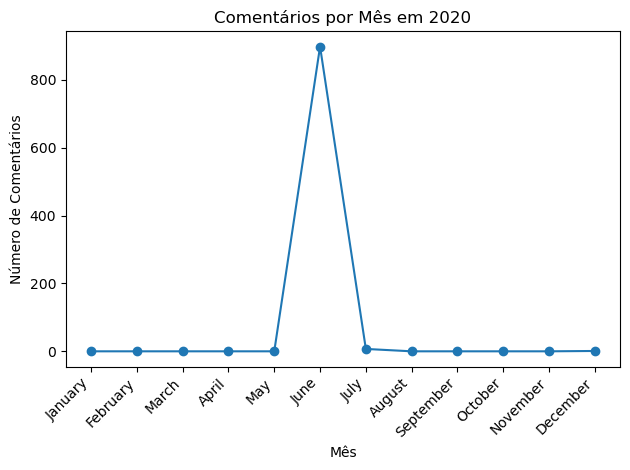

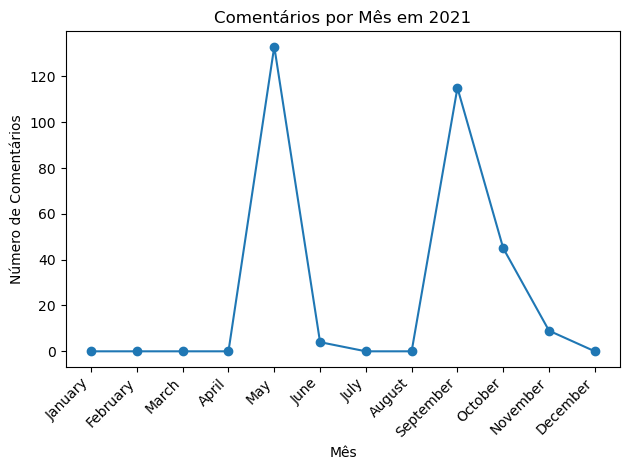

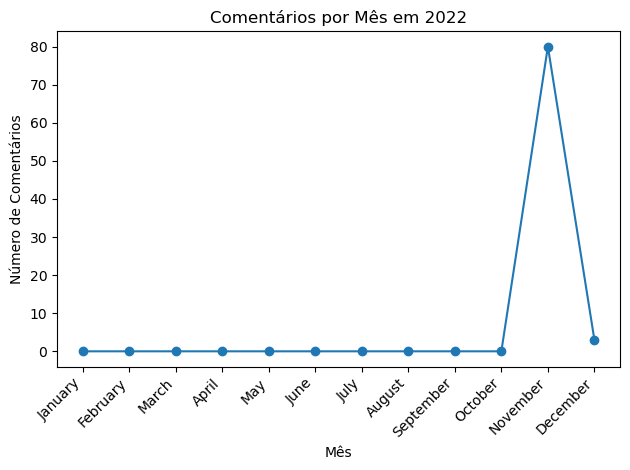

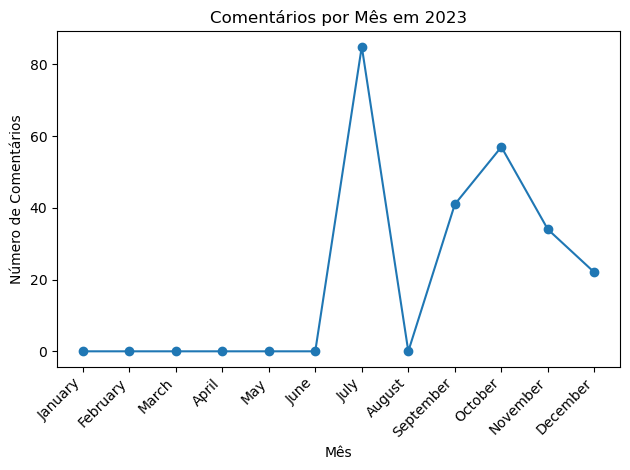

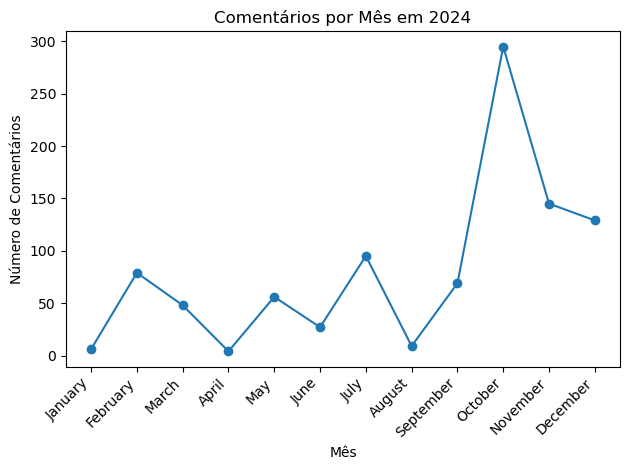

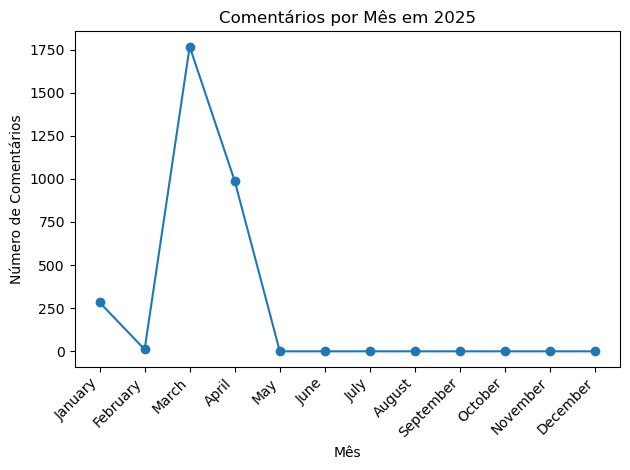

In [69]:
import calendar

# 2. Converte published_at para datetime e extrai ano e mês
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)
df['year'] = df['published_at'].dt.year
df['month'] = df['published_at'].dt.month

# 3. Filtra para ignorar anos muito distantes (por exemplo, antes de 2000)
df = df[df['year'] >= 2000]

# 4. Para cada ano presente no DataFrame, gera um gráfico mensal
for year in sorted(df['year'].unique()):
    df_year = df[df['year'] == year]
    # Agrupa por mês (1 a 12), preenchendo meses ausentes com zero
    comentarios_por_mes = df_year.groupby('month').size().reindex(range(1, 13), fill_value=0)
    
    plt.figure()
    plt.plot(comentarios_por_mes.index, comentarios_por_mes.values, marker='o')
    plt.title(f'Comentários por Mês em {year}')
    plt.xlabel('Mês')
    plt.ylabel('Número de Comentários')
    
    # Usa nomes de meses no eixo x
    labels = [calendar.month_name[m] for m in comentarios_por_mes.index]
    plt.xticks(ticks=comentarios_por_mes.index, labels=labels, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

Device set to use cpu


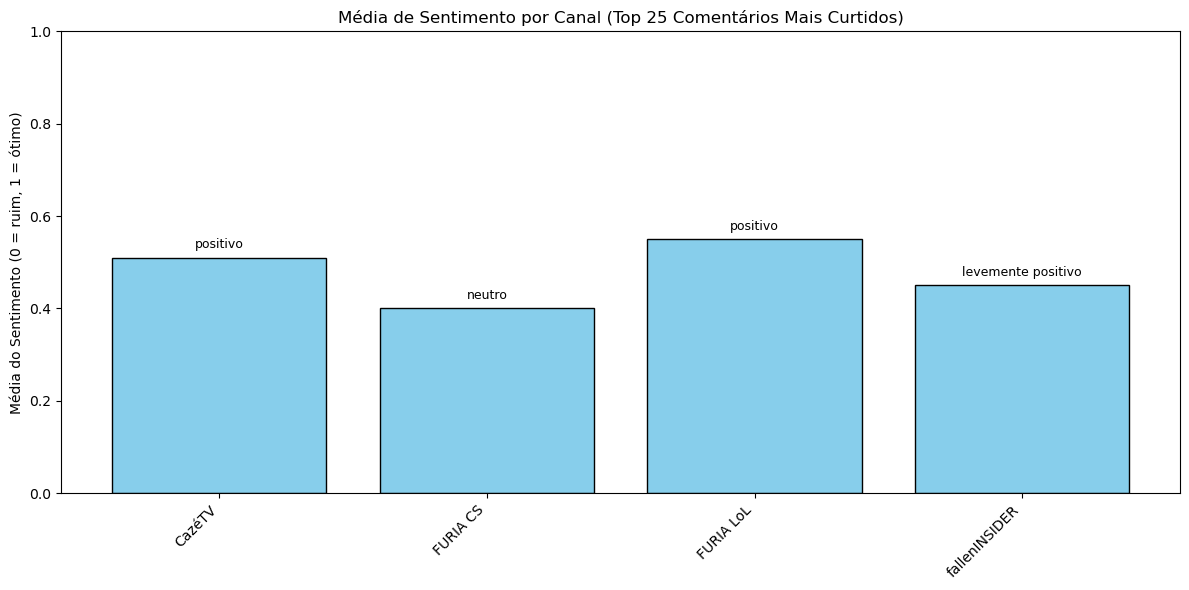

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline

# 1. Caminho do JSON
JSON_PATH = 'form_data/comentarios_video.json'

# 2. Carrega o DataFrame
df = pd.read_json(JSON_PATH)

# 3. Top 10 comentários mais curtidos por canal
top_por_canal = (
    df
    .sort_values(['channel_name', 'likes'], ascending=[True, False])
    .groupby('channel_name')
    .head(25)
)

# 4. Pipeline de sentimento
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment",
    device=-1
)

# 5. Aplica o modelo em lotes
def analyze_batch(texts):
    return sentiment_analyzer(texts, truncation=True)

results = []
batch_size = 32
texts = top_por_canal['text'].tolist()
for i in range(0, len(texts), batch_size):
    results.extend(analyze_batch(texts[i:i+batch_size]))

# 6. Processa os resultados
scores, labels = [], []
for res in results:
    stars = int(res['label'][0])
    score = (stars - 1) / 4
    if stars == 1:
        sentiment = "muito negativo"
    elif stars == 2:
        sentiment = "negativo"
    elif stars == 3:
        sentiment = "neutro"
    elif stars == 4:
        sentiment = "positivo"
    else:
        sentiment = "muito positivo"
    scores.append(score)
    labels.append(sentiment)

top_por_canal = top_por_canal.reset_index(drop=True)
top_por_canal['sentiment_score'] = scores
top_por_canal['sentiment'] = labels

# 7. Classificação por faixa de média
def classificar_media(score):
    if score <= 0.2:
        return "muito negativo"
    elif score <= 0.3:
        return "negativo"
    elif score <= 0.43:
        return "neutro"
    elif score <= 0.5:
        return "levemente positivo"
    elif score <= 0.65:
        return "positivo"
    elif score <= 0.8:
        return "muito positivo"
    else:
        return "extremamente positivo"

# 8. Agrupamento por canal com contagem
resumo_canais = (
    top_por_canal
    .groupby('channel_name')
    .agg(
        mean_sentiment_score=('sentiment_score', 'mean'),
        total_comentarios=('sentiment_score', 'count')
    )
    .reset_index()
)

# 9. Aplica rótulo textual e monta nome com contagem
resumo_canais['sentiment_class'] = resumo_canais['mean_sentiment_score'].apply(classificar_media)
resumo_canais['channel_label'] = resumo_canais.apply(
    lambda row: f"{row['channel_name']}", axis=1
)

# 10. Gráfico
plt.figure(figsize=(12, 6))
bars = plt.bar(resumo_canais['channel_label'], resumo_canais['mean_sentiment_score'], color='skyblue', edgecolor='black')
plt.ylabel('Média do Sentimento (0 = ruim, 1 = ótimo)')
plt.ylim(0, 1)
plt.title('Média de Sentimento por Canal (Top 25 Comentários Mais Curtidos)')
plt.xticks(rotation=45, ha='right')

# 11. Anota a classificação acima das barras
for bar, label in zip(bars, resumo_canais['sentiment_class']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, label, ha='center', fontsize=9)

plt.tight_layout()
plt.show()

Device set to use cpu


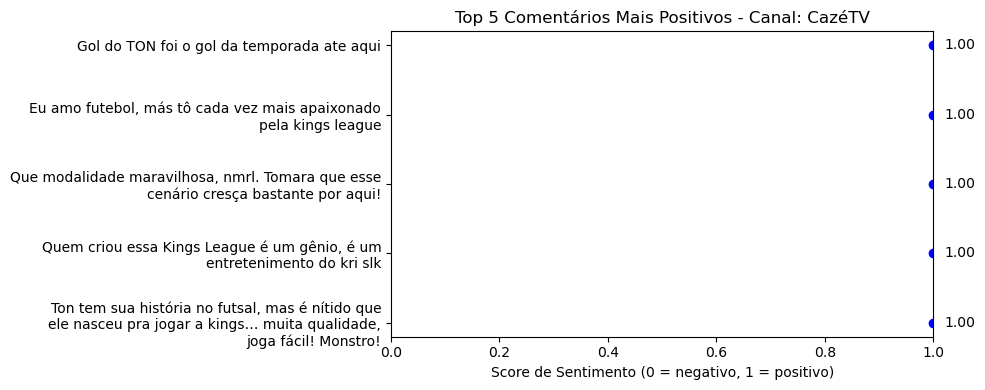

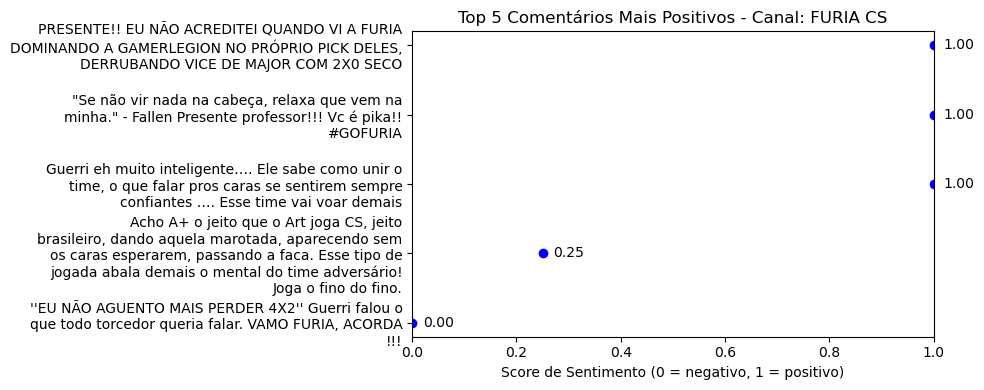

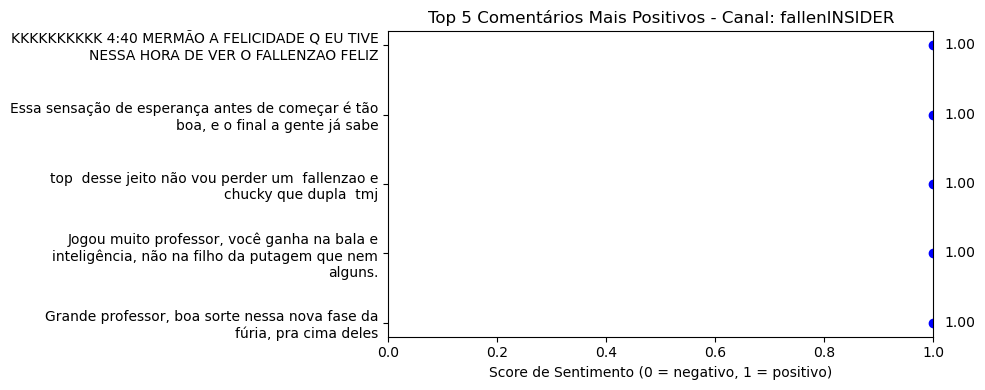

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import pipeline
import textwrap

# Lista de palavras banidas
palavras_banidas = ['CAPIM', 'Desempedidos', 'G3X', 'g3x', 'DENDELE', 'LOUD', 'FUNKBOL', 'FLUXO REAL ELITE']

# 1. Filtra os 200 melhores comentários por likes
top100 = df.sort_values('likes', ascending=False).head(200).copy()

# 2. Filtra comentários que contenham palavras banidas
top100_filtrado = top100[~top100['text'].str.upper().str.contains('|'.join(palavras_banidas))]

# 3. Cria o pipeline de análise de sentimento
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    tokenizer="nlptown/bert-base-multilingual-uncased-sentiment",
    device=-1  # CPU
)

# 4. Aplica em lotes a análise de sentimentos
results = []
batch_size = 32
texts = top100_filtrado['text'].tolist()
for i in range(0, len(texts), batch_size):
    results.extend(sentiment_analyzer(texts[i:i+batch_size], truncation=True))

# 5. Converte labels em score normalizado
scores = []
for res in results:
    stars = int(res['label'][0])
    score = (stars - 1) / 4  # normaliza para 0–1
    scores.append(score)

top100_filtrado = top100_filtrado.reset_index(drop=True)
top100_filtrado['sentiment_score'] = scores

# 6. Filtra 5 comentários por canal com base no score de sentimento
top_comentarios_canal = []

for channel, group in top100_filtrado.groupby('channel_name'):
    top_comentarios_canal.append(group.sort_values('sentiment_score', ascending=False).head(5))

# Concatena os 5 melhores comentários de cada canal
top_comentarios_canal = pd.concat(top_comentarios_canal).reset_index(drop=True)

# 7. Função para plotar gráfico individual para cada canal
def plot_comentarios_canal(df, canal):
    comentarios = [textwrap.fill(txt, width=50) for txt in df['text']]
    scores = df['sentiment_score']
    
    plt.figure(figsize=(10, len(df) * 0.8))
    bars = plt.barh(range(len(comentarios)), scores, color='green')
    plt.yticks(range(len(comentarios)), comentarios)
    plt.xlabel('Score de Sentimento (0 = negativo, 1 = positivo)')
    plt.title(f'Top 5 Comentários Mais Positivos - Canal: {canal}')
    plt.xlim(0, 1)
    plt.gca().invert_yaxis()

    # Exibe o score ao lado de cada barra
    for i, score in enumerate(scores):
        plt.text(score + 0.02, i, f'{score:.2f}', va='center')
    
    plt.tight_layout()
    plt.show()

# 8. Cria um gráfico para cada canal
for channel, group in top_comentarios_canal.groupby('channel_name'):
    plot_comentarios_canal(group, channel)


In [ ]:
#remove o cache Remove-Item -Recurse -Force "$env:USERPROFILE\.cache\huggingface"


UsageError: Line magic function `%Remove-Item` not found.


<div style="text-align: center;"> <h3>Estruturação do Notebook</h3> </div>

- Organizar o notebook em seções claras conforme as etapas acima: **Coleta de Dados**, **Validação de Identidade**, **Integração de Redes Sociais**, **Enriquecimento com Dados Sociais**, **Conclusão**.  
- Incluir explicações breves em cada seção usando células Markdown, resumindo o objetivo daquela etapa. Combinar descrições em texto com células de código demonstrativas.  
- Sugerir bibliotecas específicas no contexto de cada etapa: por exemplo, mencionar `ipywidgets` ou `streamlit` na coleta de dados, `pytesseract`/`OpenCV` na validação de documentos, `tweepy`/`PRAW`/`BeautifulSoup` na integração social, e `transformers`/`spaCy` na análise de linguagem.

<div style="text-align: center;"> <h3>Dicas de Apresentação do Protótipo</h3> </div>

- **Formatação Atraente:** Usar cabeçalhos (`#`, `##`), listas e imagens (logotipos de e-sports, ícones de redes sociais) para tornar o notebook visualmente agradável. Células Markdown bem elaboradas ajudam na legibilidade.  
- **Interatividade:** Incluir elementos interativos (sliders, botões de upload, caixas de seleção) via `ipywidgets` para simular um fluxo real de uso. Isso torna a demonstração dinâmica mesmo no ambiente de notebook.  
- **Visualização de Dados:** Aproveitar gráficos (matplotlib, seaborn ou plotly) para mostrar perfis de interesse ou resultados das análises de comentários. Um gráfico de barras ou nuvem de palavras torna o conteúdo mais didático.  
- **Narração do Código:** Inserir comentários explicativos e outputs de exemplo que guiem o avaliador pelo processo passo a passo. Ao final, apresentar um breve resumo dos resultados obtidos para evidenciar que todos os requisitos foram atendidos.  

<div style="text-align: center;"> <h3>Conclusão</h3> </div>

Este plano garante uma implementação completa dos requisitos do desafio, integrando coleta de informações pessoais e de interesse em e-sports, validação de identidade baseada em IA, simulação de integração social e enriquecimento de perfil com dados externos. A organização em seções claras, o uso de bibliotecas especializadas (ex: **Streamlit/ipywidgets** para interfaces, **OpenCV/face_recognition** para validação, **transformers/spaCy** para IA, **pandas** para dados) e as sugestões de apresentação asseguram uma entrega alinhada e de fácil acompanhamento, mesmo no formato de notebook.